# Data Analysis 

In [35]:
import os
import dotenv

dotenv.load_dotenv()
DB_HOST = os.getenv('GP_DB_HOST')
DB_PORT = os.getenv('GP_DB_PORT')
DB_USER = os.getenv('GP_DB_USER')
DB_PASS = os.getenv('GP_DB_PASS')
DB_NAME = os.getenv('GP_DB_NAME')

conString = {'host':DB_HOST,
             'user':DB_USER,
             'dbname':DB_NAME,
             'password':DB_PASS,
             'port':DB_PORT}

# Data manipulation
import pandas as pd
import numpy as np
import psycopg2
import statsmodels

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import klib
import altair as alt
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

alt.data_transformers.disable_max_rows()  # disable error for big datasets

DataTransformerRegistry.enable('default')

Variables that will be used through out the analysis

In [36]:
#Order of income groups to provide consistency while plotting
income_grp_ord = {'income_grp':['Low income','Lower middle income','Upper middle income','High income']}
#Order of regions to provide consistency while plotting
regions_ord ={'region':['East Asia & Pacific', 'Middle East & North Africa', 'Latin America & Caribbean', 'Europe & Central Asia', 'Sub-Saharan Africa', 'South Asia']}
#Colors to use when plotting categorical with 4 vars
color_dict_4 = {'High income':'rgba(16, 112, 2, 0.8)',
                                       'Upper middle income':'rgba(112, 196, 255, 1)',
                                       'Lower middle income':' rgba(226, 199, 0, 1)',
                                       'Low income':'Color: rgba(137, 0, 14, 1)'}
#Selected subset of countries for closer analysis
selected_countries = ['SGP','ESP','CHL','QAT','NZL','CHN','BGR','MEX','BRA','JOR','ZAF','SLV','IND','UKR','KEN','RWA','MLI','SEN', 'NPL','UZB']

Establishing Connection

In [37]:
conn = psycopg2.connect(**conString)
cur = conn.cursor()

Getting the data from 2009 to 2018 for all countries

In [38]:
#Loading Data
query = f'''SELECT ct.country_name, ei.country_code, ei.year, ei.val_qual_ed, hc.edu_pcnt_bud, hc.edu_pcnt_gdp, hc.hdi, hc.gdp_us, hc.gdp_percapita, hc.gdp_growth,income_grp, region
FROM edx.education_indicators AS ei INNER JOIN edx.human_capital AS hc ON ei.year = hc.year AND ei.country_code = hc.country_code
	INNER JOIN edx.country AS ct ON ct.country_code = ei.country_code
WHERE ei.year BETWEEN 2009 AND 2018 
ORDER BY ei.year DESC, ei.country_code'''

cur.execute(query= query)
edu_indicators = pd.DataFrame(cur.fetchall())

#Setting Column names
edu_indicators.columns = ['country_name', 'country_code' ,'year', 'val_qual_ed','edu_pcnt_gdp', 'edu_pcnt_bud','hdi','gdp_us','gdp_percapita','gdp_growth','income_grp','region']

Looking at the data

In [39]:
edu_indicators.head()

,country_name,country_code,year,val_qual_ed,edu_pcnt_gdp,edu_pcnt_bud,hdi,gdp_us,gdp_percapita,gdp_growth,income_grp,region
0,Aruba,ABW,2018,NaN,NaN,NaN,NaN,3.202189e+09,30253.279360,NaN,High income,Latin America & Caribbean
1,Africa Eastern and Southern,AFE,2018,NaN,17.01243,4.951635,NaN,1.011720e+12,1573.221585,2.461969,None,None
2,Islamic State of Afghanistan,AFG,2018,NaN,11.69606,3.199790,0.509,1.805323e+10,485.668419,1.189228,Low income,South Asia
3,Africa Western and Central,AFW,2018,NaN,16.33997,3.066335,NaN,7.416920e+11,1704.139603,2.952230,None,None
4,People's Republic of Angola,AGO,2018,NaN,5.41023,2.044700,0.582,1.013530e+11,3289.643995,-2.003630,Lower middle income,Sub-Saharan Africa


What does the data has

In [40]:
edu_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2650 entries, 0 to 2649
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_name   2650 non-null   object 
 1   country_code   2650 non-null   object 
 2   year           2650 non-null   int64  
 3   val_qual_ed    1255 non-null   float64
 4   edu_pcnt_gdp   1781 non-null   float64
 5   edu_pcnt_bud   1826 non-null   float64
 6   hdi            1630 non-null   float64
 7   gdp_us         2567 non-null   float64
 8   gdp_percapita  2567 non-null   float64
 9   gdp_growth     2535 non-null   float64
 10  income_grp     2160 non-null   object 
 11  region         2170 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 248.6+ KB


Visualize missing data in our overall dataset

GridSpec(6, 6)

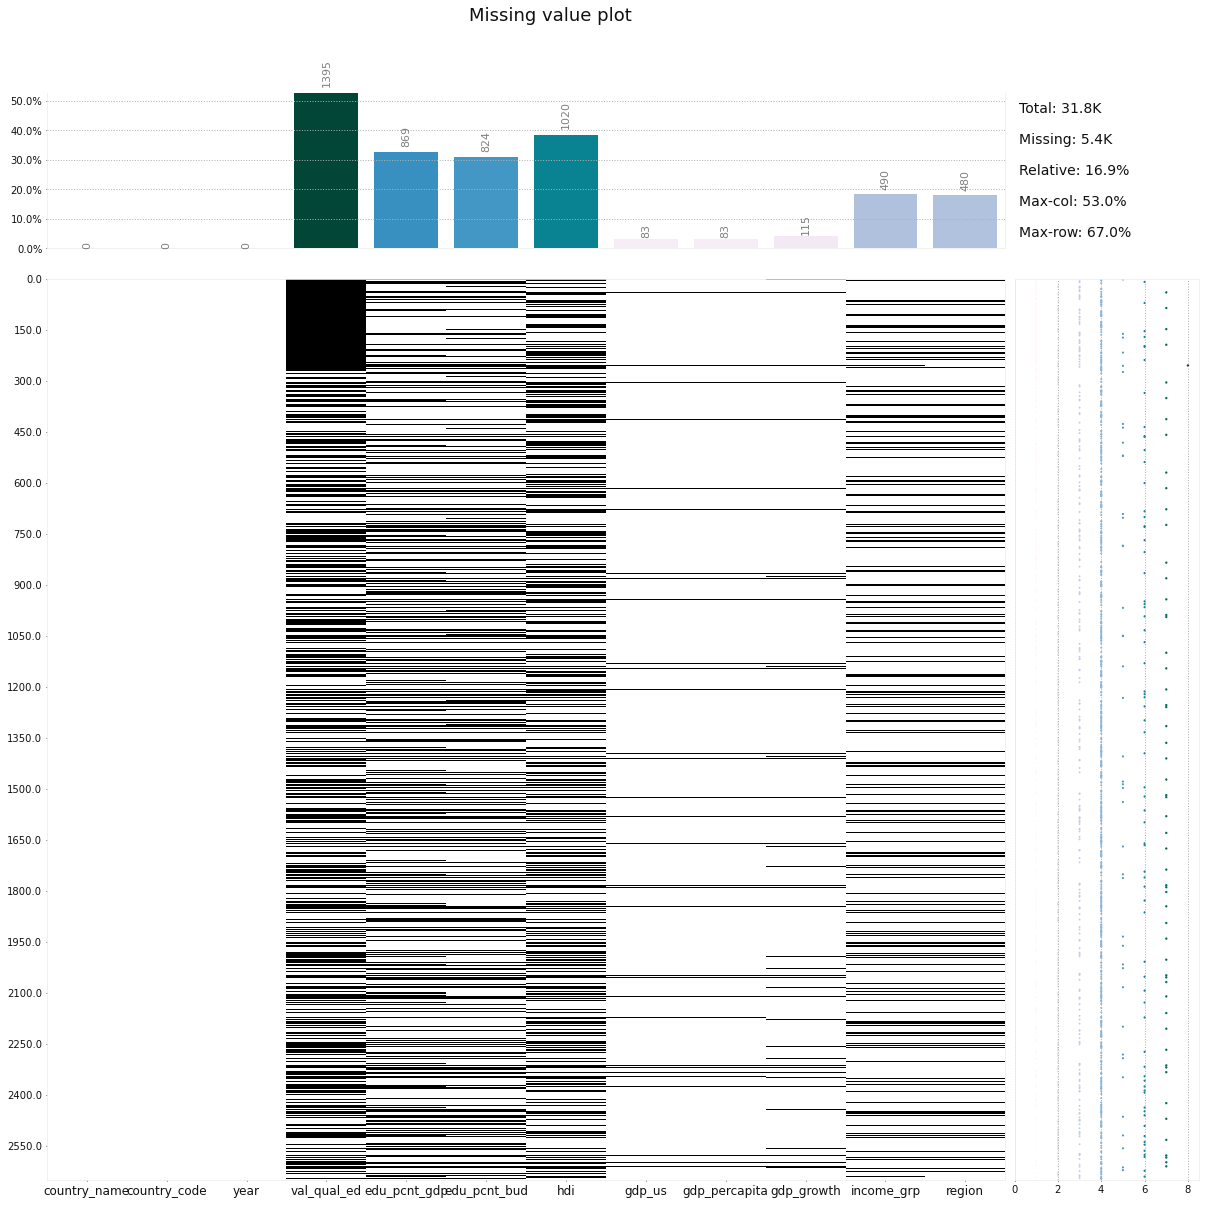

In [41]:
klib.missingval_plot(edu_indicators)

Build the cross sectional slice that we are interested in

In [42]:
edu_indicators_2017 = edu_indicators[edu_indicators['year']==2017]

Visualize the missing data in 2017 dataset

GridSpec(6, 6)

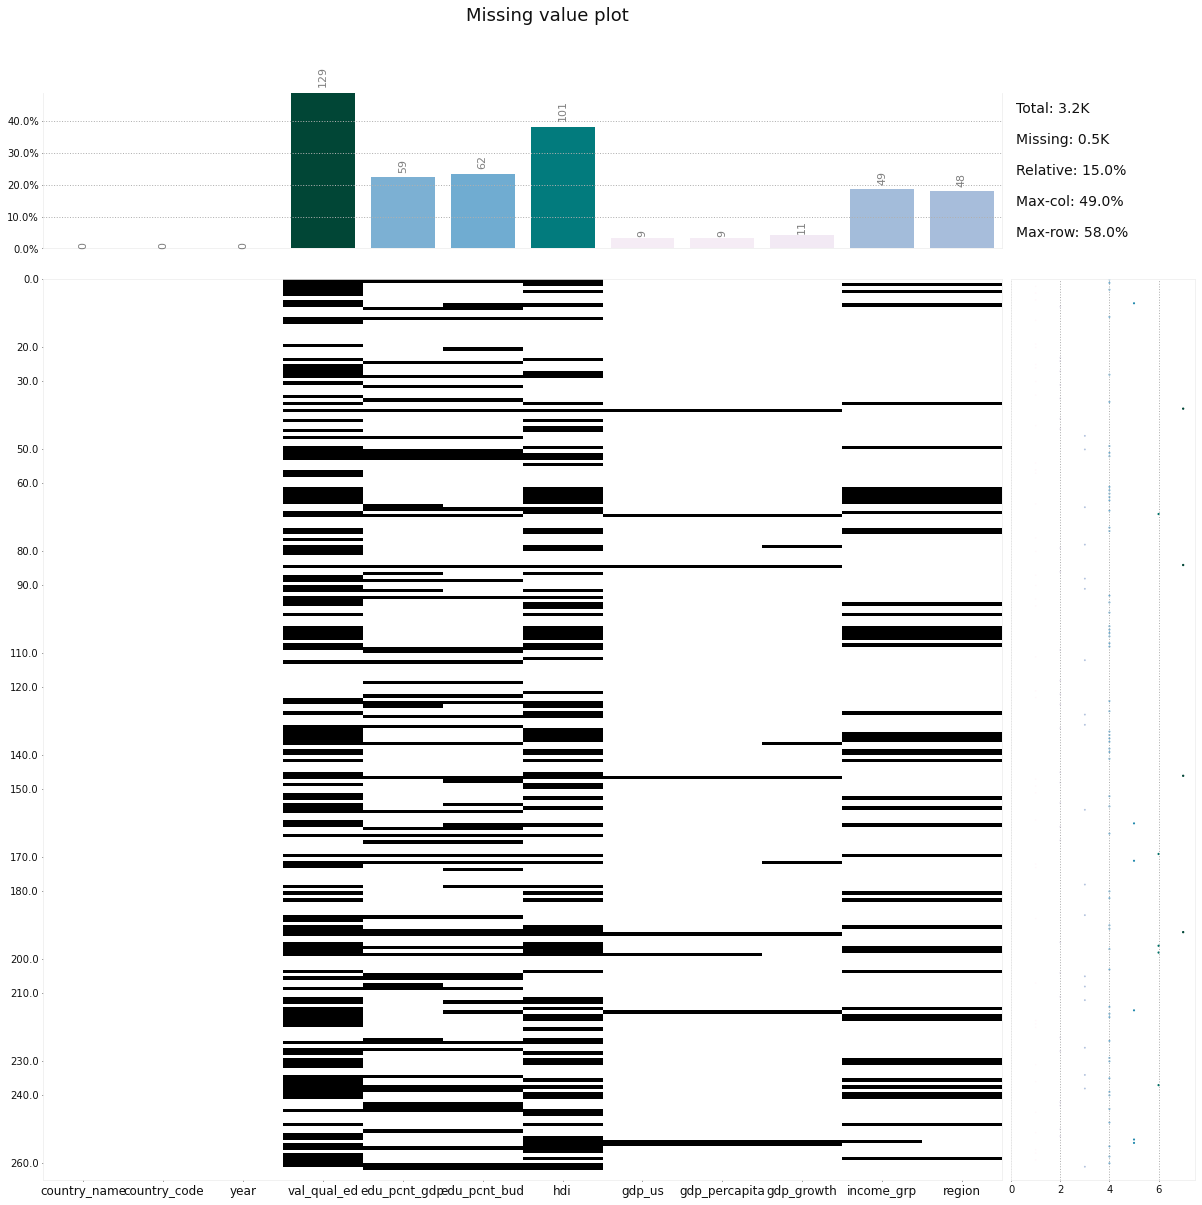

In [43]:
klib.missingval_plot(edu_indicators_2017)

### Visualize our selected Countries

We are selecting a subset of countries for deeper country wise time series analysis. The distribution of those countries attempt to balance across regions and income groups to be representative of the whole world

In [71]:
edu_indicators_selected_countries = edu_indicators_2017[edu_indicators_2017.country_code.isin(selected_countries)]
fig = px.choropleth(locations=edu_indicators_selected_countries['country_code'], 
                    locationmode="ISO-3",
                    #color_discrete_map== color_dict_4,
                    color = edu_indicators_selected_countries['income_grp'],
                    scope="world",
                    labels={'color':'Income Group'}
                   )
fig.show()

# Project Questions

### Does the education expenditure as a % of the GDP correlate with increase in quality of education?


In [46]:
#Loading the data from db
qu_gdp_qual = '''SELECT ct.country_code, ct.country_name,hc.year, edu_pcnt_bud, edu_pcnt_gdp, val_qual_ed,ct.income_grp,ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.human_capital as hc ON ei.year = hc.year and ei.country_code = hc.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = hc.country_code
WHERE edu_pcnt_gdp is not NULL and val_qual_ed is not NULL and hc.year BETWEEN 2008 and 2017'''

cur.execute(query=qu_gdp_qual)
df_gdp_qual = pd.DataFrame(cur.fetchall())

df_gdp_qual.columns = ['country_code','country_name','year','edu_pcnt_bud','edu_pcnt_gdp','val_qual_ed','income_grp','region']

df_gdp_qual = df_gdp_qual.dropna()

df_gdp_qual

,country_code,country_name,year,edu_pcnt_bud,edu_pcnt_gdp,val_qual_ed,income_grp,region
0,AGO,People's Republic of Angola,2010,8.684770,3.42132,1.775528,Lower middle income,Sub-Saharan Africa
1,AGO,People's Republic of Angola,2011,8.958500,3.24377,1.708840,Lower middle income,Sub-Saharan Africa
2,AGO,People's Republic of Angola,2013,9.693560,3.87206,2.279704,Lower middle income,Sub-Saharan Africa
3,AGO,People's Republic of Angola,2014,7.132300,2.93055,2.202184,Lower middle income,Sub-Saharan Africa
4,ALB,Republic of Albania,2013,12.123910,3.53930,4.164543,Upper middle income,Europe & Central Asia
...,...,...,...,...,...,...,...,...
1054,ZWE,Republic of Zimbabwe,2013,28.660339,5.99598,3.922407,Lower middle income,Sub-Saharan Africa
1055,ZWE,Republic of Zimbabwe,2014,30.015150,6.13835,3.930034,Lower middle income,Sub-Saharan Africa
1056,ZWE,Republic of Zimbabwe,2015,29.470831,5.81279,3.948431,Lower middle income,Sub-Saharan Africa
1057,ZWE,Republic of Zimbabwe,2016,23.527081,5.47262,3.883747,Lower middle income,Sub-Saharan Africa


Let's first see in our year of interest (i.e. 2017) Whether there was any relationship

In [47]:
#Subsetting data to get observations of 2017
df_gdp_qual_2017 = df_gdp_qual[df_gdp_qual['year'] == 2017]

In [48]:
fig = px.scatter(data_frame=df_gdp_qual_2017,x='edu_pcnt_gdp',y='val_qual_ed',hover_name='country_name',color='val_qual_ed', trendline='ols', labels={'val_qual_ed':'Quality of Education Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': "Education Exp. (%GDP) and Education Quality in 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Percentage of the GDP",
    yaxis_title="Education Quality Index"
)

fig.show()

That's surprising!! There's almost no correlation at all between the education expenditure as a % of the GDP and the Quality of Education. R^2 of 0.06.

Time to dig deeper!

Let's check if the income group has an interaction with the education expenditure (i.e. the change is affected by the income group )

In [49]:
fig = px.scatter(data_frame=df_gdp_qual_2017,x='edu_pcnt_gdp',y='val_qual_ed',facet_col='income_grp',hover_name='country_name',color='val_qual_ed', trendline='ols', 
                 category_orders=income_grp_ord, labels={'val_qual_ed':'Quality of Education Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': 'Education Exp. (% GDP) vs. Quality of Education By Income group',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='Percentage of the GDP',
    yaxis_title='Quality of Education Index',
    legend={'title':'Quality of Education Index'}
)

#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title = 'Percentage of the GDP'))

fig.show()

While the R2 across the different income groups is still low. We can see that the trend. It emphasis the gap; low income countries remain locked even if they increased the education expenditure and the high income increases as they increase the budget

Let's check if there are regional variation

In [50]:
fig = px.scatter(data_frame=df_gdp_qual_2017,x='edu_pcnt_gdp',y='val_qual_ed',color='val_qual_ed',hover_data=['country_name','year'],facet_col='region',trendline='ols', 
                 category_orders=regions_ord, labels={'val_qual_ed':'Quality of Education Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': 'Education Exp. (% GDP) vs. Quality of Education By Region',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='Percentage of the GDP',
    yaxis_title='Quality of Education Index',
    legend={'title':'Quality of Education Index'}
)

#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title = 'Percentage of the GDP'))

fig.show()

Let's check among our subset of representative countries if the change in the education expenditure as percent of the budget or the GDP had any correlation with the education quality across time

In [51]:
#Selecting the subset of selected countries to examine the effect over time 
df_gdp_qual_selected_countries = df_gdp_qual[df_gdp_qual.country_code.isin(selected_countries)]

fig = px.line(df_gdp_qual_selected_countries,x='year',y= df_gdp_qual_selected_countries.columns[3:6],facet_col='country_name',facet_col_wrap=4,height=1600, facet_col_spacing=0.03,
              labels={'variable':'Legend'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': "Relationship between Budget, GDP and Education Quality by Country",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Year",
    yaxis_title="%"
)
#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title = 'Year'))

#Ensuring that all y-axis show the correct label
fig.for_each_yaxis(lambda y: y.update(title = '%'))

fig.show()

### Does the increase in the quality of education improve social and economical welfare of people (HDI Index)?

In [52]:
#Loading the data from db
qu_hdi_qual = '''SELECT ct.country_code, ct.country_name, hc.year, hdi, val_qual_ed, ct.income_grp, ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.human_capital as hc ON ei.year = hc.year and ei.country_code = hc.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = hc.country_code
WHERE hdi is not NULL and val_qual_ed is not NULL and hc.year BETWEEN 2008 and 2017'''

cur.execute(query=qu_hdi_qual)
df_hdi_qual = pd.DataFrame(cur.fetchall())

df_hdi_qual.columns = ['country_code','country_name','year','hdi','val_qual_ed','income_grp','region']

df_hdi_qual = df_hdi_qual.dropna()

df_hdi_qual

,country_code,country_name,year,hdi,val_qual_ed,income_grp,region
0,ALB,Republic of Albania,2008,0.728,3.290243,Upper middle income,Europe & Central Asia
1,DZA,People's Democratic Republic of Algeria,2008,0.702,2.814054,Lower middle income,Middle East & North Africa
2,ARG,Argentine Republic,2008,0.821,3.510129,Upper middle income,Latin America & Caribbean
3,ARM,Republic of Armenia,2008,0.745,3.062006,Upper middle income,Europe & Central Asia
4,AUS,Commonwealth of Australia,2008,0.926,5.373493,High income,East Asia & Pacific
...,...,...,...,...,...,...,...
1220,GBR,United Kingdom of Great Britain and Northern I...,2017,0.926,5.246218,High income,Europe & Central Asia
1221,USA,United States of America,2017,0.924,5.697491,High income,North America
1222,URY,Oriental Republic of Uruguay,2017,0.814,3.902377,High income,Latin America & Caribbean
1223,ZMB,Republic of Zambia,2017,0.578,3.609120,Lower middle income,Sub-Saharan Africa


In [53]:
#Subsetting data to only the observations of 2017
df_hdi_qual_2017 = df_hdi_qual[df_hdi_qual['year'] == 2017]

In [54]:
fig = px.scatter(data_frame=df_hdi_qual_2017,x='val_qual_ed',y='hdi',hover_name='country_name',color='hdi', trendline='ols', labels={'hdi':'Humand Development Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Country",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education Index",
    yaxis_title="Human Development Index (HDI)"
)

fig.show()

In [55]:
fig = px.scatter(data_frame=df_hdi_qual_2017,x='val_qual_ed',y='hdi',facet_col='income_grp',hover_name='country_name',color='hdi',trendline='ols'
                 , category_orders= income_grp_ord, labels={'hdi':'Humand Development Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group in 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education",
    yaxis_title="Human Development Index (HDI)"
)
#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title="Quality of Education Index"))

fig.show()

In [56]:
fig = px.scatter(data_frame=df_hdi_qual_2017,x='val_qual_ed',y='hdi',facet_col='region',hover_name='country_name',color='hdi',trendline='ols',
                 category_orders= regions_ord, labels={'hdi':'Humand Development Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group in 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Quality of Education Index",
    yaxis_title="Human Development Index (HDI)"
)
#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title="Quality of Education Index"))

fig.show()

In [57]:
#Selecting the subset of selected countries to examine the effect over time 
df_hdi_qual_selected_countries = df_hdi_qual[df_hdi_qual.country_code.isin(selected_countries)]

fig = px.line(df_hdi_qual_selected_countries,x='year',y= df_hdi_qual_selected_countries.columns[3:5],facet_col='country_name',facet_col_wrap=4,height=1600, facet_col_spacing=0.03, labels={'variable':'Legend'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and Human Development Index by Income group Between 2008 and 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Year",
    yaxis_title="Index"
)

#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title="Year"))

#Ensuring that all y-axis show the correct label
fig.for_each_yaxis(lambda y: y.update(title="Index"))

fig.show()

### Do scores in international standardized tests provide a good indicator of the quality of education?

We will use PISA as an example of the international standardized tests. 

In [58]:
#Loading the data from db
qu_scores_qual = '''SELECT ct.country_code, ct.country_name, ps.year, ps.pisamath,ps.pisasci, ps.pisaread, val_qual_ed, ct.income_grp, ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.pisa_scores as ps ON ei.year = ps.year and ei.country_code = ps.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = ei.country_code
WHERE val_qual_ed is not NULL and ps.year BETWEEN 2000 and 2020 '''

cur.execute(query=qu_scores_qual)
df_scores_qual = pd.DataFrame(cur.fetchall())

df_scores_qual = df_scores_qual.dropna()

df_scores_qual.columns = ['country_code','country_name', 'year', 'pisa_math','pisa_science','pisa_reading','val_qual_ed','income_grp','region']

df_scores_qual

,country_code,country_name,year,pisa_math,pisa_science,pisa_reading,val_qual_ed,income_grp,region
0,AUS,Commonwealth of Australia,2009,514.0,527.0,515.0,5.171065,High income,East Asia & Pacific
1,AUS,Commonwealth of Australia,2012,504.0,521.0,512.0,5.300962,High income,East Asia & Pacific
2,AUS,Commonwealth of Australia,2015,494.0,510.0,503.0,5.338691,High income,East Asia & Pacific
3,AUT,Republic of Austria,2012,506.0,506.0,490.0,4.914795,High income,Europe & Central Asia
4,AUT,Republic of Austria,2015,497.0,495.0,485.0,4.785561,High income,Europe & Central Asia
...,...,...,...,...,...,...,...,...,...
112,TUR,Republic of Turkey,2012,448.0,463.0,475.0,3.757946,Upper middle income,Europe & Central Asia
113,TUR,Republic of Turkey,2015,420.0,425.0,428.0,3.687091,Upper middle income,Europe & Central Asia
114,USA,United States of America,2009,487.0,502.0,500.0,5.277301,High income,North America
115,USA,United States of America,2012,481.0,497.0,498.0,5.032046,High income,North America


Which countries are particpating in the PISA test?

In [59]:
fig = px.choropleth(locations=df_scores_qual['country_code'], 
                    locationmode="ISO-3",
                    color=df_scores_qual['income_grp'],
                    color_discrete_map= color_dict_4,
                    scope="world",
                    labels={'color':'Income Group'}
                   )

fig.show()

We can see from the graph that participants of PISA are generally high income and upper middle income ... !!!! INEQUALITY!!!!

Let's see if there are any trends in the PISA scores.

In [60]:
fig = px.scatter(data_frame=df_scores_qual,x='pisa_math',y='pisa_science',facet_col='year',hover_name='country_name',color='pisa_reading',trendline='ols', facet_col_wrap=3, labels={'pisa_reading':'PISA Reading'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': 'Correlation among PISA categories scores',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='PISA Math Score',
    yaxis_title='PISA Science Score'
)

#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title="PISA Math Score"))

fig.show()

Ok the scores are highly correlated R2 of 0.93 with each other throughout all the testing years. So it is safe to combine them without losing any trends.

We'll create 1 metric that combines all the scores together to perform our analysis.

In [61]:
df_scores_qual['pisa_combined_score'] = df_scores_qual.apply(lambda row: row['pisa_math'] + row['pisa_science'] + row['pisa_reading'],axis=1)
df_scores_qual

,country_code,country_name,year,pisa_math,pisa_science,pisa_reading,val_qual_ed,income_grp,region,pisa_combined_score
0,AUS,Commonwealth of Australia,2009,514.0,527.0,515.0,5.171065,High income,East Asia & Pacific,1556.0
1,AUS,Commonwealth of Australia,2012,504.0,521.0,512.0,5.300962,High income,East Asia & Pacific,1537.0
2,AUS,Commonwealth of Australia,2015,494.0,510.0,503.0,5.338691,High income,East Asia & Pacific,1507.0
3,AUT,Republic of Austria,2012,506.0,506.0,490.0,4.914795,High income,Europe & Central Asia,1502.0
4,AUT,Republic of Austria,2015,497.0,495.0,485.0,4.785561,High income,Europe & Central Asia,1477.0
...,...,...,...,...,...,...,...,...,...,...
112,TUR,Republic of Turkey,2012,448.0,463.0,475.0,3.757946,Upper middle income,Europe & Central Asia,1386.0
113,TUR,Republic of Turkey,2015,420.0,425.0,428.0,3.687091,Upper middle income,Europe & Central Asia,1273.0
114,USA,United States of America,2009,487.0,502.0,500.0,5.277301,High income,North America,1489.0
115,USA,United States of America,2012,481.0,497.0,498.0,5.032046,High income,North America,1476.0


In [62]:
fig = px.scatter(data_frame=df_scores_qual,x='pisa_combined_score',y='val_qual_ed',facet_col='year',hover_name='country_name',color='val_qual_ed',trendline='ols', labels={'val_qual_ed':'Education Quality Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': 'Relationship between PISA combined score vs. Quality of Education Index',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='PISA Combined Score',
    yaxis_title='Quality of Educaiton Index',
    legend={'title':'Quality of Education Index'}
)
#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title="PISA Combined Score"))

fig.show()

In [63]:
# Plotting a scatter of the PISA Combined Score and the Quality of Education; Year is differentiated by color and hovering on each point should show the country name
fig = px.scatter(data_frame=df_scores_qual,x='pisa_combined_score',y='val_qual_ed',hover_name='country_name',color='year',trendline='ols', labels={'year':'Year'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': 'Relationship between PISA combined score vs. Quality of Education Index between 2008 and 2017',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='PISA Combined Score',
    yaxis_title='Quality of Educaiton Index'
)

#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title="PISA Combined Score"))

fig.show()

### Does the increase in quality of education result in an increase in the living standards of the people (GDP)?

In [64]:
#Loading the data from db
df_qual_gpc = '''SELECT ct.country_code, ct.country_name, hc.year, gdp_percapita, val_qual_ed,gdp_us, ct.income_grp, ct.region
FROM edx.education_indicators as ei 
	INNER JOIN edx.human_capital as hc ON ei.year = hc.year and ei.country_code = hc.country_code 
	INNER JOIN edx.country as ct on ct.country_code  = hc.country_code
WHERE hdi is not NULL and val_qual_ed is not NULL and hc.year BETWEEN 2008 and 2017'''

cur.execute(query=df_qual_gpc)
df_qual_gpc = pd.DataFrame(cur.fetchall())

df_qual_gpc.columns = ['country_code','country_name','year','gdp_percapita', 'val_qual_ed','gdp_us','income_grp','region']

df_qual_gpc

,country_code,country_name,year,gdp_percapita,val_qual_ed,gdp_us,income_grp,region
0,ALB,Republic of Albania,2008,4370.539925,3.290243,1.288135e+10,Upper middle income,Europe & Central Asia
1,DZA,People's Democratic Republic of Algeria,2008,4923.631615,2.814054,1.710010e+11,Lower middle income,Middle East & North Africa
2,ARG,Argentine Republic,2008,9020.873323,3.510129,3.615580e+11,Upper middle income,Latin America & Caribbean
3,ARM,Republic of Armenia,2008,4010.861381,3.062006,1.166204e+10,Upper middle income,Europe & Central Asia
4,AUS,Commonwealth of Australia,2008,49654.910600,5.373493,1.055130e+12,High income,East Asia & Pacific
...,...,...,...,...,...,...,...,...
1220,GBR,United Kingdom of Great Britain and Northern I...,2017,40857.755580,5.246218,2.699020e+12,High income,Europe & Central Asia
1221,USA,United States of America,2017,60109.655730,5.697491,1.954300e+13,High income,North America
1222,URY,Oriental Republic of Uruguay,2017,18690.893840,3.902377,6.423397e+10,High income,Latin America & Caribbean
1223,ZMB,Republic of Zambia,2017,1535.196574,3.609120,2.587360e+10,Lower middle income,Sub-Saharan Africa


In [65]:
df_qual_gpc_2017 = df_qual_gpc[df_qual_gpc['year']==2017]

In [66]:
fig = px.scatter(data_frame=df_qual_gpc_2017,x='gdp_percapita',y='val_qual_ed',hover_name='country_name',color='val_qual_ed',trendline='ols',log_x=True, labels={'val_qual_ed':'Education Quality Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': 'Relationship between GDP per Capita vs. Quality of Education Index in 2017',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='GDP per Capita',
    yaxis_title='Quality of Educaiton Index',
    legend={'title':'Quality of Education Index'}
)

fig.show()

In [67]:
fig = px.scatter(data_frame=df_qual_gpc_2017,x='val_qual_ed',y='gdp_percapita',hover_name='country_name',color='val_qual_ed',trendline='ols',log_y=False, labels={'val_qual_ed':'Education Quality Index'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': 'Relationship between GDP per Capita vs. Quality of Education Index in 2017',
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title='Quality of Educaiton Index',
    yaxis_title='GDP per Capita',
    legend={'title':'Quality of Education Index'}
)

fig.show()

In [68]:
#Selecting the subset of selected countries to examine the effect over time 
df_qual_gpc_selected_countries = df_qual_gpc[df_qual_gpc.country_code.isin(selected_countries)]

fig = px.line(df_qual_gpc_selected_countries,x='year',y= df_qual_gpc_selected_countries.columns[3:5],facet_col='country_name',facet_col_wrap=4,height=1600, facet_col_spacing=0.03, labels={'variable':'Legend'})

#Setting the labels of the plot
fig.update_layout(
    title={
        'text': "Relationship between Quality of Education and GDP per Capita Between 2008 and 2017",
        'x':0.5,
        'xanchor': 'center'},
    xaxis_title="Year",
    yaxis_title="Index",
)

#Ensuring that all x-axis show the correct label
fig.for_each_xaxis(lambda x: x.update(title="Year"))

#Ensuring that all y-axis show the correct label
fig.for_each_yaxis(lambda y: y.update(title="Index"))
fig.show()

Closing Connection

In [72]:
#conn.close()